In [2]:
from tqdm import tqdm
from pymongo import MongoClient
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
import urllib
import requests
import json
import bson
import time
%matplotlib inline

## Load Reframe data

In [3]:
# source: Sebastian Burgstaller
reframe = pd.read_csv("reframe_compounds.csv", index_col=0)
reframe.head()

,inchi_key,inchi,orig_smiles,can_smiles,iso_smiles,cid,sids,chem_names,unii,trivial_name,chembl,surechembl,chebi
0,WXGNWUVNYMJENI-UHFFFAOYSA-N,InChI=1S/C2H2F4/c3-1(4)2(5)6/h1-2H,C(C(F)(F))(F)F,NaN,NaN,CID9667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ONCYRMPVWWXSGC-BVWFLDLOSA-N,InChI=1S/C37H40N6O13/c1-2-37(23-14-27-32-20(13...,N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O))CCC(=O)O)...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HECMXPDHJXQWCF-IZEVAHMFSA-N,InChI=1S/C80H83Cl2N9O32/c1-27(95)85-60-66(104)...,N[C@H]1[C@@H](O[C@@H]([C@H]([C@@H]1O)O)CO)Oc1c...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,KAVDAMFOTJIBCK-CTNBOOGPSA-N,InChI=1S/C12H15BrN2O4/c13-2-1-7-5-15(12(19)14-...,Br/C=C/c1cn([C@@H]2C[C@@H]([C@H](C2)O)CO)c(=O)...,NaN,NaN,CID6479188,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ODZBBRURCPAEIQ-PIXDULNESA-N,InChI=1S/C11H13BrN2O5/c12-2-1-6-4-14(11(18)13-...,Br/C=C/c1cn([C@H]2C[C@@H]([C@H](O2)CO)O)c(=O)[...,NaN,NaN,CID446727,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
reframe_pubchem = set(list(reframe.cid))
reframe_inchi_key = set(list(reframe.inchi_key))
reframe_inchi0 = set(x.split('-',1)[0] for x in reframe_inchi_key)
print("number of reframe compounds: {}".format(len(reframe)))
print("number of unique reframe pubchem ids: {}".format(len(reframe_pubchem)))
print("number of unique reframe inchi keys: {}".format(len(reframe_inchi_key)))
print("number of unique reframe inchi connectivities: {}".format(len(reframe_inchi0)))


number of reframe compounds: 10116
number of unique reframe pubchem ids: 9034
number of unique reframe inchi keys: 10068
number of unique reframe inchi connectivities: 9684


## Load in L1000 perturbation info

In [5]:
# source: "download l1000 metadata info.ipynb"
with open("l1000_pertinfo.json") as f:
    l1000_pertinfo = json.load(f)
l1000_pertinfo = {x['pert_id']:x for x in l1000_pertinfo}
l1000 = pd.DataFrame(l1000_pertinfo).T
l1000.pubchem_cid = l1000.pubchem_cid.apply(lambda x: "CID" + str(x) if not pd.isnull(x) else x)
l1000.inchi_key = l1000.inchi_key.apply(lambda x: str(x).replace("InChIKey=","") if not pd.isnull(x) else x)
l1000[~l1000.inchi_key.isnull()].head(2)


,_id,alt_name,canonical_smiles,cell_id,clone_name,in_summly,inchi_key,inchi_string,logp,mls_id,...,pert_vendor,pubchem_cid,seed_seq6,seed_seq7,sig_id,sig_id_gold,structure_url,target_region,target_seq,vector_id
BRD-A00100033,515b60e1a8898537028bd15b,NaN,CC1CS(=O)(=O)CCN1N=Cc2ccc(o2)[N+](=O)[O-],"[HA1E, HCC515, PC3, VCAP, A375, A549, ASC, HEP...",NaN,NaN,ARFHIAQFJWUCFH-UHFFFAOYSA-N,"InChI=1S/C10H13N3O5S/c1-8-7-19(16,17)5-4-12(8)...",-0.27,NaN,...,Prestwick,CID6842999,NaN,NaN,"[CPC003_HA1E_6H:BRD-A00100033-001-04-8:10, CPC...",[CPC015_A375_6H:BRD-A00100033-001-04-8:10],http://data.lincscloud.org/pert_images/BRD-A00...,NaN,NaN,NaN
BRD-A00150179,515b6108a8898537028c6186,NaN,NC(Cc1c[nH]c2cccc(O)c12)C(O)=O,"[FIBRNPC, NEU, NEU.KCL, NPC]",NaN,NaN,QSHLMQDRPXXYEE-UHFFFAOYSA-N,InChI=1S/C11H12N2O3/c12-7(11(15)16)4-6-5-13-8-...,-1.53,NaN,...,Enzo,CID589768,NaN,NaN,"[NMH001_FIBRNPC_6H:BRD-A00150179-001-01-3:10, ...","[NMH001_FIBRNPC_24H:BRD-A00150179-001-01-3:10,...",http://data.lincscloud.org/pert_images/BRD-A00...,NaN,NaN,NaN


In [6]:
l1000_drug = l1000.query("pert_type == 'trt_cp'")
l1000_pubchem = set(list(l1000_drug.pubchem_cid.dropna()))
l1000_inchi_key = set(list(l1000_drug.inchi_key.dropna()))
l1000_inchi0 = set(x.split('-',1)[0] for x in l1000_inchi_key)
print("number of L1000 drug perturbations: {}".format(len(l1000_drug)))
print("number of unique L1000 pubchem ids: {}".format(len(l1000_pubchem)))
print("number of unique L1000 inchi keys: {}".format(len(l1000_inchi_key)))
print("number of unique L1000 inchi connectivities: {}".format(len(l1000_inchi0)))

number of L1000 drug perturbations: 20413
number of unique L1000 pubchem ids: 20139
number of unique L1000 inchi keys: 20308
number of unique L1000 inchi connectivities: 9170


In [33]:
l1000_drug['inchi0'] = l1000_drug['inchi_key'].map(lambda x:x.split('-')[0] if not isinstance(x, float) else '')

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


## Compare overlap

In [34]:
print("pubchem")
print(len(l1000_pubchem))
print(len(reframe_pubchem))
print(len(l1000_pubchem & reframe_pubchem))

pubchem
20139
9034
1030


In [35]:
print("inchi_key")
print(len(l1000_inchi_key))
print(len(reframe_inchi_key))
both_inchi = l1000_inchi_key & reframe_inchi_key
print(len(both_inchi))

inchi_key
20308
10068
1309


In [36]:
# Compare the connectivity part of the inchi key only
print("inchi_key connectivity")
print(len(l1000_inchi0))
print(len(reframe_inchi0))
both_inchi0 = l1000_inchi0 & reframe_inchi0
print(len(both_inchi0))

inchi_key connectivity
9170
9684
1568


## What collections are the overlapping drugs coming from?
http://support.lincscloud.org/hc/en-us/articles/204502059-Perturbagen-Collection-Definitions

In [47]:
l1000_drug.pert_collection.value_counts()
# There are a large number of l1000 compounds from CBLI: 
# CBLI - Chemical Biology Production Libraries: These are compounds from the diversity-oriented synthesis (DOS) 
# efforts of the Broad Chemical Biology Platform.  This collection contains large (> 1000 compounds) subsets
# elaborated from matrices of related, stereochemically diverse scaffolds, poised for ready access to elucidation
# of structure activity relationships.

CBLI    12644
BIOA     4184
TBD      1304
STRD     1161
SOLN      405
COMB      308
COMA      120
KINA      114
CHRM      100
NATP       38
GPCR        6
IONC        2
NUCR        1
PROT        1
Name: pert_collection, dtype: int64

In [46]:
l1000_drug[l1000_drug.inchi0.isin(both_inchi0)].drop_duplicates("inchi0").pert_collection.value_counts()
# Almost all of the overlapping drugs (between L1000 and reframe) are from the BIOA collection

BIOA    1545
COMB       8
STRD       5
TBD        3
NATP       2
KINA       1
Name: pert_collection, dtype: int64

### Its weird L1000 has 20k drug perturbations but 10k unique connectivities, isn't it?

In [48]:
inchi_count = {k:v for k,v in Counter(l1000_drug['inchi0'].dropna()).items() if v>1}
l1000_drug[l1000_drug.inchi0.isin(inchi_count.keys())].pert_collection.value_counts()
# yes, they come from CBLI

CBLI    12106
BIOA     1064
TBD       759
SOLN      388
CHRM       68
STRD       54
COMB        7
NATP        2
GPCR        1
Name: pert_collection, dtype: int64

### Of all assays in L1000 using compounds, on average, how many replicates are done per collection?

In [56]:
pertid_collection = l1000_drug.pert_collection.to_dict()
pertid_inchi = l1000_drug.inchi_key.to_dict()
pertid_inchi0 = l1000_drug.inchi0.to_dict()
pertid_name = l1000_drug.pert_iname.to_dict()

In [57]:
df = pd.read_csv("L1000_LINCScloud.csv", index_col=0)
df = df.query("pert_type == 'trt_cp'")
df['inchi'] = df.pert_id.map(lambda x: pertid_inchi.get(x,''))
df['inchi0'] = df.pert_id.map(lambda x: pertid_inchi0.get(x,''))
df['pert_collection'] = df.pert_id.map(lambda x: pertid_collection.get(x,''))
df['pert_name'] = df.pert_id.map(lambda x: pertid_name.get(x,''))

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [149]:
x={}
for name, group in df.groupby("pert_collection"):
    x[name]=group.groupby("pert_id").agg({'_id':len})['_id'].mean()
x

{'': 27.0,
 'BIOA': 24.270076481835563,
 'CBLI': 4.612385321100917,
 'CHRM': 17.08,
 'COMA': 20.541666666666668,
 'COMB': 20.67207792207792,
 'GPCR': 14.166666666666666,
 'IONC': 13.0,
 'KINA': 19.359649122807017,
 'NATP': 18.68421052631579,
 'NUCR': 13.0,
 'PROT': 17.0,
 'SOLN': 3.2790123456790123,
 'STRD': 15.074935400516797,
 'TBD': 6.106758832565284}

In [167]:
# What is the composition of assays by collection, relative to number of compounds?
x = pd.DataFrame([l1000_drug.pert_collection.value_counts(),df.pert_collection.value_counts()])
x.index = ['drugs', 'assays']
x=x[x.columns[1:]]
x=x.div(x.sum(axis=1), axis=0)
x

,BIOA,CBLI,CHRM,COMA,COMB,GPCR,IONC,KINA,NATP,NUCR,PROT,SOLN,STRD,TBD
drugs,0.205219,0.620169,0.004905,0.005886,0.015107,0.000294,0.000098,0.005592,0.001864,0.000049,0.000049,0.019865,0.056945,0.063959
assays,0.507111,0.291240,0.008530,0.012310,0.031796,0.000424,0.000130,0.011022,0.003546,0.000065,0.000085,0.006632,0.087403,0.039707


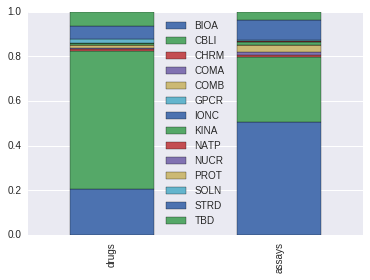

In [168]:
x.plot.bar(stacked=True)

### What are the overlapping compounds?
#### ordered by most used (# of reps)

In [70]:
df[df.inchi0.isin(both_inchi0)].pert_name.value_counts().sort_values(ascending=False).head()

vorinostat    481
sirolimus     413
wortmannin    296
estradiol     282
tozasertib    262
Name: pert_name, dtype: int64

In [75]:
#-------___________-------------

In [49]:
len(set(df.pert_id))

20413

In [ ]:
df_both = df[df.inchi.isin(both_inchi)]

In [ ]:
"JWUBBDSIWDLEOM" in l1000_inchi0

In [119]:
# To query biothings.drugs
id_mapping = {}
for inchi in tqdm(l1000_inchi0):
    id_mapping[inchi] = {'pubchem':[],'drugbank':[]}
    results = requests.get("http://su01:8000/v1/query?size=100&q=pubchem.inchi_key:{}*".format(inchi)).json()
    for result in results['hits']:
        if 'pubchem' in result:
            id_mapping[inchi]['pubchem'].append(result['pubchem']['cid'])
        if 'drugbank' in result:
            if 'accession_number' in result['drugbank']:
                id_mapping[inchi]['drugbank'].extend(result['drugbank']['accession_number'])
            if 'drugbank_id' in result['drugbank']:
                id_mapping[inchi]['drugbank'].append(result['drugbank']['drugbank_id'])
    time.sleep(0.5)

100%|██████████| 9170/9170 [1:23:15<00:00,  1.91it/s]


In [121]:
with open("id_mapping_inchi0.json",'w') as f:
    json.dump(id_mapping, f)

In [123]:
dfid = pd.DataFrame(id_mapping).T
print(dfid.drugbank.map(lambda x:len(x)!=0).value_counts())
print(dfid.pubchem.map(lambda x:len(x)!=0).value_counts())

False    8034
True     1136
Name: drugbank, dtype: int64
True     9067
False     103
Name: pubchem, dtype: int64


In [ ]:
client = MongoClient("wl-cmadmin.scripps.edu", 27020)
db = client.LINCS_L1000_CD.LINCScloud
print("Total: {}".format(db.find({'pert_type':'trt_cp'}).count()))
keys = {'pert_id','pert_desc'}
df_lincs = pd.DataFrame(list(db.find({'pert_type':'trt_cp'},{k:1 for k in keys})))
pertids = set(list(df_lincs.pert_id))

In [79]:
x=list(l1000_pubchem & reframe_pubchem)[:10]
x

['CID5288674',
 'CID32170',
 'CID5281792',
 'CID16654980',
 'CID5394',
 'CID1989',
 'CID9824562',
 'CID51173',
 'CID379077',
 'CID26098']

In [83]:
url

'http://su01:8000/v1/query?size=100&q=pubchem.cid:CID5288674,CID32170,CID5281792,CID16654980,CID5394,CID1989,CID9824562,CID51173,CID379077,CID26098'